<a href="https://colab.research.google.com/github/fmejias/CS534-ArtificialIntelligenceProject/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS 534 - Artificial Intelligence**

## **Project Title: Text Mining and Sentiment Analysis on Twitter for predicting students dropping out during the pandemic.**

### **Students**


*   Merzia Adamjee
*   Alketa Guxha
*   Felipe Mejias
*   Nikita Boguslavskii




# **Initial configuration of the environment for the development of the project**

In [ ]:
from google.colab import drive
from google.colab import files
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Install Textblob and Imbalanced Learn**

In [ ]:
!pip install textblob
!pip install imbalanced-learn
!pip3 install flair

# **Google Authentication to read CSV File from Google Drive**

In [ ]:
# Needed for Google Authentication Step
drive.mount('/content/drive')

Mounted at /content/drive


# **Upload Dataset from Google Drive**

In [ ]:
DATASET_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part1_labeled.csv"
dataset_df = pd.read_csv(DATASET_PATH, sep=";")

# **Dataset Information**

In [ ]:
# Print a summary of the Dataset
result = dataset_df.head(10)
print("First 10 rows of the DataFrame:")
print(result)

# **Dataset Preprocessing**

## **Select labeled dataset**

In [ ]:
# NOTE: This selection is because all the dataset is labeled
labeled_dataset_df = dataset_df

## **Check for imbalance classes**

Number of rows with intention of dropout:  1094
Number of rows with no intention of dropout:  2025


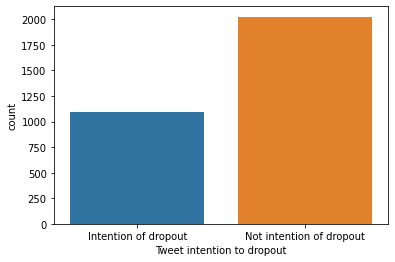

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Number of rows with intention of dropout: ", 
      len(labeled_dataset_df[(labeled_dataset_df['label'] == "Intention of dropout")]))
print("Number of rows with no intention of dropout: ", 
      len(labeled_dataset_df[(labeled_dataset_df['label'] == "Not intention of dropout")]))

sns.countplot(labeled_dataset_df.label)
plt.xlabel('Tweet intention to dropout');

## **Convert label to numerical value**

In [ ]:
# Convert label categorical value to numerical value
label_numerical_value = labeled_dataset_df["label"].astype('category').cat.codes
labeled_dataset_df["label"] = label_numerical_value

## **Filtering irrelevant examples**

In [ ]:
IRRELEVANT_KEYWORDS = ["Bernie", "Trump", "Sanders", "to become", 
                       "to pursue", "and becoming", "and going",
                       "and be", "so I can", "so i can", "to run",
                       "to spend", "to focus", "and living", "marry",
                       "stripper", "and joining", "and pursuing",
                       "bts", "BTS", "and running", "to go", "and making",
                       "to dedicate"]

def filtering_irrelevant_examples(twitter_dataset):
  """
  Filtering irrelevant tweets from the Twitter dataset.
  """
  def check_tweet_relevance(tweet):
    """
    Filtering irrelevant tweets from the Twitter dataset.
    """
    if any(indicator in tweet for indicator in IRRELEVANT_KEYWORDS):
      return "irrelevant"
    return "relevant"
  return twitter_dataset[twitter_dataset["tweet"].apply(check_tweet_relevance) \
                         != "irrelevant"]

# Filter the irrelevant tweets
labeled_dataset_df = filtering_irrelevant_examples(labeled_dataset_df)
rows, columns = labeled_dataset_df.shape
print("New number of rows: ", rows)

New number of rows:  2577


## **Convert all letters to lower case**

In [ ]:
def convert_letters_to_lower_case(twitter_dataset):
  """
  Convert all letters to lower case.
  """
  def tweet_to_lower_case(tweet):
    """
    Convert tweet text to lower case.
    """
    return tweet.lower()

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(tweet_to_lower_case)

# Convert all tweets to lower case
convert_letters_to_lower_case(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after lower case:")
print(result)

First 10 rows of the DataFrame after lower case:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


## **Remove usernames that appear within a tweet**

In [ ]:
def remove_usernames_from_tweets(twitter_dataset):
  """
  Remove all usernames that appear on a tweet.
  """
  def remove_username(tweet):
    """
    Remove username from tweet.
    """
    return re.sub('@[\w]+','', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_username)

# Remove all usernames that appear in a tweet
remove_usernames_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


## **Remove hashtags that appear within a tweet**

In [ ]:
def remove_hashtags_from_tweets(twitter_dataset):
  """
  Remove all hashtags that appear on a tweet.
  """
  def remove_hashtags(tweet):
    """
    Remove hashtags from tweet.
    """
    return tweet.replace("#", "").replace("_", " ")

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_hashtags)

# Remove all hashtags that appear in a tweet
remove_hashtags_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


## **Remove special characters and punctuation that appear within a tweet**

In [ ]:
def remove_special_characters_and_punctuation_from_tweets(twitter_dataset):
  """
  Remove all special characters and punctuation that appear on a tweet.
  """
  def remove_special_characters_and_punctuation(tweet):
    """
    Remove special characters and punctuation from tweet.
    """
    return re.sub('[^A-Za-z0-9 ]+', '', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_special_characters_and_punctuation)

# Remove all special characters and punctuation that appear in a tweet
remove_special_characters_and_punctuation_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


## **Remove URLs that appear within a tweet**

In [ ]:
def remove_urls_from_tweets(twitter_dataset):
  """
  Remove all urls that appear on a tweet.
  """
  def remove_urls(tweet):
    """
    Remove urls from tweet.
    """
    return re.sub(r'http\S+', '', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_urls)

# Remove all urls that appear in a tweet
remove_urls_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


## **Remove stop words that appear within a tweet**

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

def remove_stop_words_from_tweets(twitter_dataset):
  """
  Remove all stop_words that appear on a tweet.
  """
  def remove_stop_words(tweet):
    """
    Remove stop_words from tweet.
    """
    return remove_stopwords(tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_stop_words)

# Remove all stop_words that appear in a tweet
remove_stop_words_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... label
0   1309219160828895233  ...     0
1   1308809031583236096  ...     1
2   1308716552229998593  ...     1
3   1308483739584835585  ...     1
4   1308351921875345409  ...     1
5   1307763236062650368  ...     1
7   1306800980307083267  ...     1
8   1305869148463992832  ...     1
9   1305659343971311616  ...     1
10  1305617685020053512  ...     1

[10 rows x 3 columns]


# **Approach using Sentiment Analysis**

## **Create features using sentiment analysis and unigrams and Textblob**

In [ ]:
from textblob import TextBlob

def calculate_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    for word in tweet.split():
      polarity_score = TextBlob(word).polarity
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    for word in tweet.split():
      polarity_score = TextBlob(word).polarity
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["unigram_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["unigram_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... unigram_negative_score
0   1309219160828895233  ...                  -0.40
1   1308809031583236096  ...                   0.00
2   1308716552229998593  ...                  -0.30
3   1308483739584835585  ...                   0.00
4   1308351921875345409  ...                  -0.25
5   1307763236062650368  ...                   0.00
7   1306800980307083267  ...                   0.00
8   1305869148463992832  ...                   0.00
9   1305659343971311616  ...                   0.00
10  1305617685020053512  ...                  -0.70

[10 rows x 9 columns]


## **Create features using sentiment analysis and bigrams and Textblob**

In [ ]:
from textblob import TextBlob

def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_bigram_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["bigram_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["bigram_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["bigram_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["bigram_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["bigram_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["bigram_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_bigram_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... bigram_negative_score
0   1309219160828895233  ...                 -0.80
1   1308809031583236096  ...                  0.00
2   1308716552229998593  ...                 -0.60
3   1308483739584835585  ...                  0.00
4   1308351921875345409  ...                 -0.50
5   1307763236062650368  ...                  0.00
7   1306800980307083267  ...                  0.00
8   1305869148463992832  ...                  0.00
9   1305659343971311616  ...                  0.00
10  1305617685020053512  ...                 -0.75

[10 rows x 15 columns]


## **Create features using sentiment analysis and trigrams and Textblob**

In [ ]:
from textblob import TextBlob

def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_trigrams_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["trigrams_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["trigrams_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["trigrams_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["trigrams_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["trigrams_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["trigrams_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_trigrams_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... trigrams_negative_score
0   1309219160828895233  ...                   -1.20
1   1308809031583236096  ...                    0.00
2   1308716552229998593  ...                   -0.67
3   1308483739584835585  ...                    0.00
4   1308351921875345409  ...                   -0.75
5   1307763236062650368  ...                    0.00
7   1306800980307083267  ...                    0.00
8   1305869148463992832  ...                    0.00
9   1305659343971311616  ...                    0.00
10  1305617685020053512  ...                   -0.80

[10 rows x 21 columns]


## **Create features using sentiment analysis and unigrams and Vader**

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sentiment_analyzer = SentimentIntensityAnalyzer()

In [ ]:
def calculate_features_using_polarity_vader(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_vader_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_vader_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity_vader(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... unigram_vader_ratio_negative_words
0   1309219160828895233  ...                           0.111111
1   1308809031583236096  ...                           0.047619
2   1308716552229998593  ...                           0.173913
3   1308483739584835585  ...                           0.142857
4   1308351921875345409  ...                           0.181818
5   1307763236062650368  ...                           0.047619
7   1306800980307083267  ...                           0.000000
8   1305869148463992832  ...                           0.055556
9   1305659343971311616  ...                           0.000000
10  1305617685020053512  ...                           0.111111

[10 rows x 25 columns]


## **Create features using sentiment analysis and bigrams and Vader**

In [ ]:
def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_bigram_vader_features_using_polarity(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["bigram_vader_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["bigram_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["bigram_vader_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["bigram_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["bigram_vader_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["bigram_vader_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_bigram_vader_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... bigram_vader_negative_score
0   1309219160828895233  ...                     -0.9102
1   1308809031583236096  ...                     -0.8038
2   1308716552229998593  ...                     -2.9129
3   1308483739584835585  ...                     -0.3818
4   1308351921875345409  ...                     -0.3759
5   1307763236062650368  ...                     -0.5464
7   1306800980307083267  ...                      0.0000
8   1305869148463992832  ...                     -0.3062
9   1305659343971311616  ...                      0.0000
10  1305617685020053512  ...                     -1.1657

[10 rows x 31 columns]


## **Create features using sentiment analysis and trigrams and Vader**

In [ ]:
def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_trigrams_vader_features_using_polarity(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] > 0:
        number_of_positive_trigrams = number_of_positive_trigrams + 1
    return number_of_positive_trigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] >= 0:
        number_of_positive_trigrams = number_of_positive_trigrams + 1
    return number_of_positive_trigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_trigrams = number_of_negative_trigrams + 1
    return number_of_negative_trigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_trigrams = number_of_negative_trigrams + 1
    return number_of_negative_trigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["trigrams_vader_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["trigrams_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["trigrams_vader_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["trigrams_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["trigrams_vader_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["trigrams_vader_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_trigrams_vader_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... trigrams_vader_negative_score
0   1309219160828895233  ...                       -1.2062
1   1308809031583236096  ...                       -1.2057
2   1308716552229998593  ...                       -4.2286
3   1308483739584835585  ...                        0.0000
4   1308351921875345409  ...                       -0.3050
5   1307763236062650368  ...                       -0.8196
7   1306800980307083267  ...                        0.0000
8   1305869148463992832  ...                       -0.4593
9   1305659343971311616  ...                        0.0000
10  1305617685020053512  ...                       -1.2557

[10 rows x 37 columns]


## **Create features using sentiment analysis and trigrams and Flair**

In [ ]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2020-11-09 15:39:27,682 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_3.1.pt not found in cache, downloading to /tmp/tmpmzj63kpy


100%|██████████| 266147697/266147697 [00:45<00:00, 5905403.55B/s]

2020-11-09 15:40:13,579 copying /tmp/tmpmzj63kpy to cache at /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


2020-11-09 15:40:14,244 removing temp file /tmp/tmpmzj63kpy
2020-11-09 15:40:14,277 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


In [ ]:
def calculate_features_using_polarity_flair(twitter_dataset):
  """
  Use flair polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_positive_words_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    positive_words_score = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        positive_words_score = positive_words_score + s.labels[0].score
    return positive_words_score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_negative_words_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    negative_words_score = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        negative_words_score = negative_words_score + s.labels[0].score
    return negative_words_score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_flair_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_flair_positive_words_score"] = twitter_dataset["tweet"].apply(calculate_positive_words_score)
  twitter_dataset["unigram_flair_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_flair_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_flair_negative_words_score"] = twitter_dataset["tweet"].apply(calculate_negative_words_score)
  twitter_dataset["unigram_flair_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity_flair(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
                     id  ... unigram_flair_ratio_negative_words
0   1309219160828895233  ...                                0.0
1   1308809031583236096  ...                                0.0
2   1308716552229998593  ...                                0.0
3   1308483739584835585  ...                                0.0
4   1308351921875345409  ...                                0.0
5   1307763236062650368  ...                                0.0
7   1306800980307083267  ...                                0.0
8   1305869148463992832  ...                                0.0
9   1305659343971311616  ...                                0.0
10  1305617685020053512  ...                                0.0

[10 rows x 43 columns]


## **Download Pandas Dataframe that contains all the extracted features**

In [ ]:
from google.colab import files
labeled_dataset_df.to_csv('dropping_out_tweets_part1_labeled_with_features.csv')
files.download('dropping_out_tweets_part1_labeled_with_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 ## **Add Polarity Score of the entire tweet as a feature**

In [ ]:
from textblob import TextBlob

def calculate_features_using_polarity_score(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_textblob_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    return TextBlob(tweet).polarity
  
  def calculate_vader_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    return sentiment_analyzer.polarity_scores(tweet)["compound"]
  
  def calculate_flair_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    s = flair.data.Sentence(tweet)
    flair_sentiment.predict(s)
    return s.labels[0].score if len(s.labels) > 0 else 0
  
  twitter_dataset["unigram_textblob_score"] = twitter_dataset["tweet"].apply(calculate_textblob_score)
  twitter_dataset["unigram_vader_score"] = twitter_dataset["tweet"].apply(calculate_vader_score)
  twitter_dataset["unigram_flair_score"] = twitter_dataset["tweet"].apply(calculate_flair_score)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity_score(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

## **Download Pandas Dataframe that contains all the extracted features**

In [ ]:
from google.colab import files
labeled_dataset_df.to_csv('dropping_out_tweets_part1_labeled_with_features.csv')
files.download('dropping_out_tweets_part1_labeled_with_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Extract features from words using Bag of Words, TF-IDF and Word2Vec**

### **Tokenization of all the tweets before normalization**

In [ ]:
tokenized_tweet_df = labeled_dataset_df.tweet.apply(lambda tweet: tweet.split())
tokenized_tweet_df.head()

0    [lost, jobs, pandemic, got, 2, new, jobs, augu...
1    [curveball, spector, work, area, pandemic, cli...
2    [socioeconomic, fallout, pandemic, billions, c...
3    [imagine, dropping, school, host, parties, pan...
4    [drop, school, challenge, naming, past, school...
Name: tweet, dtype: object

### **Normalization of the tokenized tweets**

In [ ]:
from nltk.stem.porter import * 

stemmer = PorterStemmer() 
tokenized_tweet_df = tokenized_tweet_df.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet_df.head()

0    [lost, job, pandem, got, 2, new, job, august, ...
1    [curvebal, spector, work, area, pandem, client...
2    [socioeconom, fallout, pandem, billion, childr...
3    [imagin, drop, school, host, parti, pandem, em...
4    [drop, school, challeng, name, past, school, d...
Name: tweet, dtype: object

### **Stitch tokens back together into tweets**

In [ ]:
for i in range(len(tokenized_tweet_df)):
    tokenized_tweet_df.iloc[i] = ' '.join(tokenized_tweet_df.iloc[i])    
labeled_dataset_df['tweet'] = tokenized_tweet_df

S:  ['lost', 'job', 'pandem', 'got', '2', 'new', 'job', 'august', 'let', 'budget', 'cut', 'hour', 'decreas', 'strugglingim', 'think', 'drop', 'school', 'jbchanceholi']
S:  ['curvebal', 'spector', 'work', 'area', 'pandem', 'client', 'come', 'issu', 'drop', 'workschool', 'social', 'isol', 'pandem', 'detriment', 'domain', 'lot', 'peopl', 'look', 'like', 'game', 'addict']
S:  ['socioeconom', 'fallout', 'pandem', 'billion', 'children', 'high', 'risk', 'forc', 'labor', 'market', 'experienc', 'sexual', 'exploit', 'teenag', 'pregnanc', 'earli', 'marriag', 'domest', 'violenc', 'amp', 'fall', 'drop', 'school']
S:  ['imagin', 'drop', 'school', 'host', 'parti', 'pandem', 'embarrass']
S:  ['drop', 'school', 'challeng', 'name', 'past', 'school', 'drop', 'school', 'pandem', 'choic', 'idk']


0     lost job pandem got 2 new job august let budge...
1     curvebal spector work area pandem client come ...
2     socioeconom fallout pandem billion children hi...
3        imagin drop school host parti pandem embarrass
4     drop school challeng name past school drop sch...
5     girl quit school work covidhit rural india nep...
7     pandem rob lowincom american colleg degre anal...
8     india privat school head teacher particularli ...
9     19 guarante wasnt drop school open restaur glo...
10    drop grad school bc man tinder told pandem ove...
Name: tweet, dtype: object

### **Bag of words features**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(labeled_dataset_df['tweet'])
bow.shape

(2577, 1000)

### **TD-IDF features**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(labeled_dataset_df['tweet'])
tfidf.shape

(2577, 1000)

### **Word2Vec features**

In [ ]:
%%time

tokenized_tweet = labeled_dataset_df['tweet'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_tweet, total_examples= len(labeled_dataset_df['tweet']), epochs=20)

CPU times: user 11.6 s, sys: 146 ms, total: 11.7 s
Wall time: 6.64 s


In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet.iloc[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(2577, 200)

### **Lead with imbalance classes using Bag of Words Features**

In [ ]:
# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(bow, labeled_dataset_df.label)

### **Training models with Bag of Words features**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9185570844179992
Training Precision:  0.950366151342555
Training Recall:  0.8808446455505279
Training F-measure:  0.9142857142857144

Test Accuracy:  0.8439821693907875
Test Precision:  0.8858024691358025
Test Recall:  0.8084507042253521
Test F-measure:  0.8453608247422681


### **Lead with imbalance classes using TD-IDF Features**

In [ ]:
# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(tfidf, labeled_dataset_df.label)

### **Training models with TD-IDF features**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.9025660096690219
Training Precision:  0.9058734939759037
Training Recall:  0.8977611940298508
Training F-measure:  0.9017991004497753

Test Accuracy:  0.8543833580980683
Test Precision:  0.8521739130434782
Test Recall:  0.8621700879765396
Test F-measure:  0.8571428571428571


### **Lead with imbalance classes using Word2Vec Features**

In [ ]:
# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(wordvec_df, labeled_dataset_df.label)

### **Training models with Word2Vec features**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8315358869468203
Training Precision:  0.8531300160513644
Training Recall:  0.7974493623405852
Training F-measure:  0.824350523458705

Test Accuracy:  0.8410104011887073
Test Precision:  0.8685015290519877
Test Recall:  0.8160919540229885
Test F-measure:  0.8414814814814814


## **Select features to train**

In [ ]:
COMPLETE_LIST_OF_FEATURES = ["unigram_number_positive_words", 
                                                 "unigram_ratio_positive_words", 
                                                 "unigram_number_negative_words", 
                                                 "unigram_ratio_negative_words",
                                                 "unigram_positive_score",
                                                 "unigram_negative_score",
                                                 "bigram_number_positive_words", 
                                                 "bigram_ratio_positive_words", 
                                                 "bigram_number_negative_words", 
                                                 "bigram_ratio_negative_words",
                                                 "bigram_positive_score",
                                                 "bigram_negative_score",
                                                 "trigrams_number_positive_words", 
                                                 "trigrams_ratio_positive_words", 
                                                 "trigrams_number_negative_words", 
                                                 "trigrams_ratio_negative_words",
                                                 "trigrams_positive_score",
                                                 "trigrams_negative_score",
                                                 "unigram_vader_positive_words", 
                                                 "unigram_vader_ratio_positive_words", 
                                                 "unigram_vader_negative_words", 
                                                 "unigram_vader_ratio_negative_words",
                                                 "bigram_vader_number_positive_words", 
                                                 "bigram_vader_ratio_positive_words", 
                                                 "bigram_vader_number_negative_words", 
                                                 "bigram_vader_ratio_negative_words",
                                                 "bigram_vader_positive_score",
                                                 "bigram_vader_negative_score",
                                                 "trigrams_vader_number_positive_words", 
                                                 "trigrams_vader_ratio_positive_words", 
                                                 "trigrams_vader_number_negative_words", 
                                                 "trigrams_vader_ratio_negative_words",
                                                 "trigrams_vader_positive_score",
                                                 "trigrams_vader_negative_score",
                                                 "unigram_vader_positive_words",
                                                 "unigram_flair_positive_words",
                                                 "unigram_flair_positive_words_score",
                                                 "unigram_flair_ratio_positive_words",
                                                 "unigram_textblob_score", 
                                                 "unigram_vader_score", 
                                                 "unigram_flair_score"]

In [ ]:
# Select calculated features
dataset_sentiment_features = labeled_dataset_df[["trigrams_number_positive_words", 
                                                 "trigrams_ratio_positive_words", 
                                                 "trigrams_number_negative_words", 
                                                 "trigrams_ratio_negative_words",
                                                 "trigrams_positive_score",
                                                 "trigrams_negative_score",
                                                 "unigram_vader_positive_words", 
                                                 "unigram_vader_ratio_positive_words", 
                                                 "unigram_vader_negative_words", 
                                                 "unigram_vader_ratio_negative_words",
                                                 "bigram_vader_number_positive_words", 
                                                 "bigram_vader_ratio_positive_words", 
                                                 "bigram_vader_number_negative_words", 
                                                 "bigram_vader_ratio_negative_words",
                                                 "bigram_vader_positive_score",
                                                 "bigram_vader_negative_score",
                                                 "unigram_flair_positive_words",
                                                 "unigram_flair_positive_words_score",
                                                 "unigram_flair_ratio_positive_words",
                                                 "unigram_textblob_score", 
                                                 "unigram_vader_score", 
                                                 "unigram_flair_score"]]

## **Normalize calculated features using Pandas**

In [ ]:
# Normalize using the mean value
normalized_df = (dataset_sentiment_features - dataset_sentiment_features.mean())/dataset_sentiment_features.std()

# Show results
result = normalized_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
    trigrams_number_positive_words  ...  unigram_flair_score
0                         0.497719  ...             0.296592
1                         0.497719  ...             0.422858
2                         2.565799  ...             0.425922
3                        -0.743128  ...             0.490862
4                        -0.743128  ...            -0.024302
5                        -0.743128  ...             0.452969
7                         0.497719  ...             0.487882
8                         1.738567  ...            -1.010269
9                        -0.743128  ...            -1.690904
10                        0.084103  ...             0.381205

[10 rows x 11 columns]


## **Normalize calculated features using Scaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Normalize using the mean value
sc = StandardScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

## **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

## **Select X and Y**

In [ ]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return dataset_sentiment_features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

## **Handle imbalance classes using SMOTE**

In [ ]:
print("Number of rows with intention of dropout: ", 
      len(labeled_dataset_df[(labeled_dataset_df['label'] == "Intention of dropout")]))
print("Number of rows with no intention of dropout: ", 
      len(labeled_dataset_df[(labeled_dataset_df['label'] == "Not intention of dropout")]))

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

Number of rows with intention of dropout:  0
Number of rows with no intention of dropout:  0


## **Train logistic regression model**

In [ ]:
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
logistic_classifier = LogisticRegression(random_state = 0).fit(X_train,
                                                               Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7013759761993306
Training Precision:  0.728448275862069
Training Recall:  0.6339084771192798
Training F-measure:  0.6778981147212194

Test Accuracy:  0.7102526002971769
Test Precision:  0.7508196721311475
Test Recall:  0.6580459770114943
Test F-measure:  0.7013782542113323


## **Train Random Forest Classifier model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
random_forest_classifier = RandomForestClassifier(n_estimators=100)
random_forest_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = random_forest_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = random_forest_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.995165489029379
Training Precision:  0.9955290611028316
Training Recall:  0.9947877885331348
Training F-measure:  0.9951582867783985

Test Accuracy:  0.8202080237741456
Test Precision:  0.8297872340425532
Test Recall:  0.8076923076923077
Test F-measure:  0.8185907046476762


## **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## **Find the parameters that optimize the Random Forest Model**

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

## **Show the parameters that has to be use in Random Forest for the selected Dataset**

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

## **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
best_random = rf_random.best_estimator_

# Calculate training accuracy
Y_pred = best_random.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = best_random.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

## **Train Adaboost Classifier model**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
adaboost_classifier = AdaBoostClassifier(n_estimators = 100)
adaboost_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = adaboost_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = adaboost_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7512086277426553
Training Precision:  0.750748502994012
Training Recall:  0.7490664675130695
Training F-measure:  0.7499065420560747

Test Accuracy:  0.7265973254086181
Test Precision:  0.7365269461077845
Test Recall:  0.7192982456140351
Test F-measure:  0.7278106508875739


## **Train Gradient Boost Classifier model**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
gradient_boost_classifier = GradientBoostingClassifier(n_estimators = 100)
gradient_boost_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = gradient_boost_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = gradient_boost_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8095946448493864
Training Precision:  0.8065476190476191
Training Recall:  0.811377245508982
Training F-measure:  0.8089552238805969

Test Accuracy:  0.7548291233283804
Test Precision:  0.7631578947368421
Test Recall:  0.7565217391304347
Test F-measure:  0.7598253275109169


## **Train XG Gradient Boost Classifier model**

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
xg_gradient_boost_classifier = xgb.XGBClassifier(objective="binary:logistic", 
                                                 random_state=42)
xg_gradient_boost_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = xg_gradient_boost_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = xg_gradient_boost_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7995537374488657
Training Precision:  0.7940320232896652
Training Recall:  0.8099480326651819
Training F-measure:  0.8019110621095186

Test Accuracy:  0.7429420505200595
Test Precision:  0.7417417417417418
Test Recall:  0.7395209580838323
Test F-measure:  0.7406296851574213


## **Train Multinomial Naive Bayes Classifier model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(Y_train, Y_pred))

## **Train Decision Tree Classifier model**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = decision_tree_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = decision_tree_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.995909259947936
Training Precision:  0.9992559523809523
Training Recall:  0.9926090169992609
Training F-measure:  0.9959213941416389

Test Accuracy:  0.7533432392273403
Test Precision:  0.7396449704142012
Test Recall:  0.7621951219512195
Test F-measure:  0.7507507507507507


## **Set the grid parameters to be optimized for Decision Tree**

In [ ]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"criterion": ["gini", "entropy"],
              "min_samples_split": randint(1, 20),
              "max_depth": randint(1, 20),
              "min_samples_leaf": randint(1, 20),
              "max_leaf_nodes": randint(2, 20)}

## **Find the parameters that optimize the Decision Tree Model**

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
decision_tree = DecisionTreeClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
decision_tree_random = RandomizedSearchCV(estimator = decision_tree, param_distributions = param_dist, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, 
                               n_jobs = -1)

# Fit the random search model
decision_tree_random.fit(X_train, Y_train)

## **Show the parameters that has to be use in Decision Tree for the selected Dataset**

In [ ]:
decision_tree_random.best_params_

{'criterion': 'entropy',
 'max_depth': 18,
 'max_leaf_nodes': 18,
 'min_samples_leaf': 7,
 'min_samples_split': 5}

## **Train Decision Tree Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
best_decision_tree_random = decision_tree_random.best_estimator_

# Calculate training accuracy
Y_pred = best_decision_tree_random.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = best_decision_tree_random.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7281517292673857
Training Precision:  0.7177871148459384
Training Recall:  0.7575757575757576
Training F-measure:  0.7371449119021936

Test Accuracy:  0.7028231797919762
Test Precision:  0.6787709497206704
Test Recall:  0.7408536585365854
Test F-measure:  0.7084548104956268


## **Train SVM model**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7370769802900706
Training Precision:  0.7434885556432518
Training Recall:  0.7114803625377644
Training F-measure:  0.7271323813199536

Test Accuracy:  0.7161961367013373
Test Precision:  0.7455621301775148
Test Recall:  0.7058823529411765
Test F-measure:  0.725179856115108


## **Train Ridge Classifier model**

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = ridge_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = ridge_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7076980290070658
Training Precision:  0.7412060301507538
Training Recall:  0.6497797356828194
Training F-measure:  0.6924882629107982

Test Accuracy:  0.6864784546805349
Test Precision:  0.6812080536912751
Test Recall:  0.6363636363636364
Test F-measure:  0.6580226904376013


## **Train Stacking Ensemble model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', GaussianNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('cart', DecisionTreeClassifier()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.995909259947936
Training Precision:  0.9977511244377811
Training Recall:  0.9940253920836445
Training F-measure:  0.9958847736625515

Test Accuracy:  0.7890044576523031
Test Precision:  0.7923976608187134
Test Recall:  0.7923976608187134
Test F-measure:  0.7923976608187134


# **Student Dropout Classification using BERT Features**

## **Install transformers library**

In [ ]:
!pip install transformers

## **Import necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

## **Load pretrained BERT models**

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## **Tokenize tweets using BERT Tokenizer**

In [ ]:
tokenized = labeled_dataset_df["tweet"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

## **Padded tokenize values**

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

## **Add the attention mask**

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

## **Calculate the BERT Features**

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

## **Select the BERT features**

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

## **Select the labels**

In [ ]:
labels = labeled_dataset_df["label"]

## **Split the train and test data**

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

## **Train a Logistic Regression Model using BERT Features**

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_clf.score(test_features, test_labels)

0.8325581395348837

## **Training and test different models**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_features, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
decision_tree.score(test_features, test_labels)

0.7348837209302326

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the model
random_forest_classifier = RandomForestClassifier(n_estimators=100)
random_forest_classifier.fit(train_features, train_labels)

# Calculate training accuracy
random_forest_classifier.score(test_features, test_labels)

0.8155038759689922

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(train_features, train_labels)

svm_classifier.score(test_features, test_labels)

0.8046511627906977

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', GaussianNB()))
base_learners.append(('rf', RandomForestClassifier()))
base_learners.append(('lr', LogisticRegression()))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 4)

stacking_ensemble.fit(train_features, train_labels)

stacking_ensemble.score(test_features, test_labels)

0.8325581395348837

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Train the model
xg_gradient_boost_classifier = xgb.XGBClassifier(objective="binary:logistic", 
                                                 random_state=42)
xg_gradient_boost_classifier.fit(train_features, train_labels)

xg_gradient_boost_classifier.score(test_features, test_labels)

0.8170542635658915

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Train the model
gradient_boost_classifier = GradientBoostingClassifier(n_estimators = 100)
gradient_boost_classifier.fit(train_features, train_labels)

gradient_boost_classifier.score(test_features, test_labels)

0.8108527131782945

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(train_features, train_labels)

eclf1.score(test_features, test_labels)

0.8248062015503876

In [ ]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier()
clf.fit(train_features, train_labels)

clf.score(test_features, test_labels)

0.8418604651162791

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

clf = PassiveAggressiveClassifier(max_iter=1000, random_state=0,tol=1e-3)
clf.fit(train_features, train_labels)

clf.score(test_features, test_labels)

0.7410852713178294

# **Fine-tuning BERT for Student Dropout Classification**

## **Install the Transformers Library**

In [ ]:
!pip install transformers

## **Install necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Specify GPU
device = torch.device("cuda")

## **Load the dataset**

In [ ]:
DATASET_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part1_labeled.csv"
dataset_df = pd.read_csv(DATASET_PATH, sep=";")

## **Convert label to numerical value**

In [ ]:
# Convert label categorical value to numerical value
label_numerical_value = dataset_df["label"].astype('category').cat.codes
dataset_df["label"] = label_numerical_value

## **Split the dataset**

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(dataset_df['tweet'], dataset_df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=dataset_df['label'])

# We will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

## **Import BERT model and BERT Tokenizer**

In [ ]:
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## **Tokenize the tweets**

### **Check the length of all the tweets**

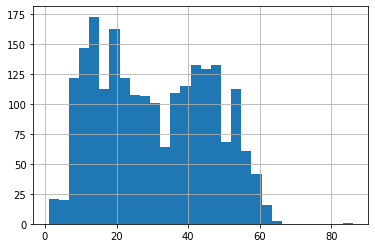

In [ ]:
# Get length of all the tweets in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

### **Set the padding length**

In [ ]:
max_seq_len = 50

### **Tokenize the tweets**

In [ ]:
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## **Convert integer sequences to tensors**

In [ ]:
# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## **Create Data Loaders**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## **Freeze BERT parameters**

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## **Define model architecture**

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

## **Find class weights**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.42493473 0.77028934]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

## **Fine-tune BERT**

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## **Start model training**

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.643
Validation Loss: 0.512

 Epoch 2 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.536
Validation Loss: 0.474

 Epoch 3 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.523
Validation Loss: 0.459

 Epoch 4 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.513
Validation Loss: 0.525

 Epoch 5 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.498
Validation Loss: 0.420

 Epoch 6 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.509
Validation Loss: 0.453

 Epoch 7 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.492
Validation Loss: 0.442

 Epoch 8 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.485
Validation Loss: 0.405

 Epoch 9 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.495
Validation Loss: 0.438

 Epoch 10 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.483
Validation L

## **Load saved model**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## **Get predictions for test data**

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       164
           1       0.93      0.81      0.87       304

    accuracy                           0.84       468
   macro avg       0.82      0.85      0.83       468
weighted avg       0.85      0.84      0.84       468



# **Fine-tuning XLNet for Student Dropout Classification**

## **Install the Transformers Library**

In [ ]:
!pip install transformers

## **Import necessary libraries**

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import XLNetForSequenceClassification, XLNetModel, XLNetTokenizer
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

## **Set GPU**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## **Load the dataset**

In [ ]:
DATASET_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part1_labeled.csv"
dataset_df = pd.read_csv(DATASET_PATH, sep=";")

## **Convert label to numerical value**

In [ ]:
# Convert label categorical value to numerical value
label_numerical_value = dataset_df["label"].astype('category').cat.codes
dataset_df["label"] = label_numerical_value

## **Add XLNet special tokens**

In [ ]:
# Create tweet and label lists
tweets = dataset_df.tweet.values

tweets = [tweet + " [SEP] [CLS]" for tweet in tweets]
labels = dataset_df.label.values

## **Tokenize tweets**

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_tweets = [tokenizer.tokenize(tweet) for tweet in tweets]
print ("Tokenize the first sentence:")
print (tokenized_tweets[0])


Tokenize the first sentence:
['▁', '@', 'just', 'in', 'bie', 'ber', '▁', '@', 'ch', 'ance', 'the', 'ra', 'pper', '▁', 'i', '▁lost', '▁both', '▁my', '▁jobs', '▁during', '▁the', '▁pandemic', '.', '▁', 'i', '▁then', '▁got', '▁2', '▁new', '▁jobs', '▁during', '▁a', 'ugu', 'st', '.', '▁', 'i', '▁had', '▁to', '▁be', '▁let', '▁go', '▁of', '▁one', '▁because', '▁of', '▁budget', '▁cuts', ',', '▁and', '▁my', '▁hours', '▁were', '▁decreased', '▁at', '▁the', '▁other', '.', '▁', 'i', '▁am', '▁struggling', ',', 'i', '’', 'm', '▁thinking', '▁of', '▁dropping', '▁out', '▁of', '▁school', '.', '▁', '#', 'j', 'b', 'ch', 'ance', 'ho', 'ly', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


## **Set maximum sequence length**

In [ ]:
MAX_LEN = 128

In [ ]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_tweets]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

## **Create attention masks**

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

## **Split train and test data**

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

## **Convert data into Torch Tensors**

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## **Training the model**

In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.45156860182231123


Epoch:  25%|██▌       | 1/4 [02:32<07:37, 152.41s/it]

Validation Accuracy: 0.8489583333333334
Train loss: 0.29824153740297665


Epoch:  50%|█████     | 2/4 [05:04<05:04, 152.32s/it]

Validation Accuracy: 0.8625
Train loss: 0.24690783159299332


Epoch:  75%|███████▌  | 3/4 [07:36<02:32, 152.20s/it]

Validation Accuracy: 0.8760416666666666
Train loss: 0.20996623681011525


Epoch: 100%|██████████| 4/4 [10:08<00:00, 152.10s/it]

Validation Accuracy: 0.8927083333333334
